# Test out `topp.py`, `util.py`, `io.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import src.io as io
import src.topp as topp
import src.util as util
from src.communicate import CableRobot
plt.rc('axes', unicode_minus=False)  # Glyph 8722

/Users/gerry/miniforge3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
strokes = io.load_log('logs/G.txt')
for stroke in strokes:
    print(stroke.shape)

(105, 3)


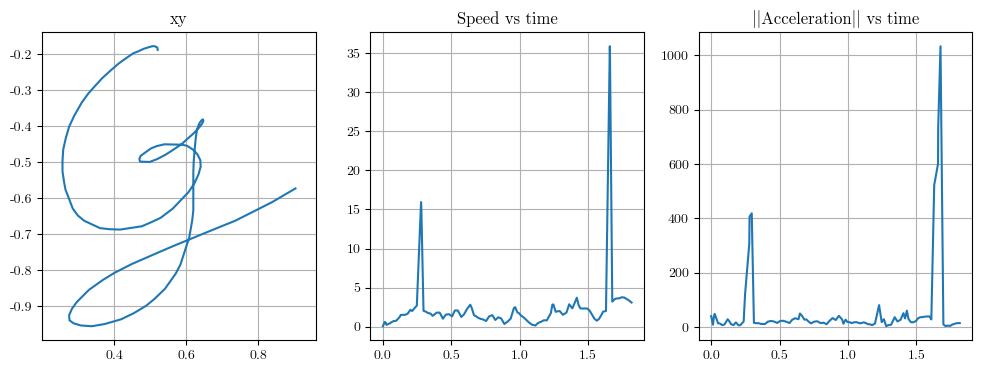

In [4]:
# Plot strokes
strokes = util.clean_strokes(strokes)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for t, xy in util.strokes2txs(strokes):
    xydot, xyddot = util.derivatives(t, xy)
    axes[0].plot(*xy.T)
    axes[1].plot(t, np.linalg.norm(xydot, axis=1))
    axes[2].plot(t, np.linalg.norm(xyddot, axis=1))
axes[0].axis('equal')
axes[0].set_title('xy')
axes[1].set_title('Speed vs time')
axes[2].set_title('||Acceleration|| vs time');

In [5]:
# Do TOPP-RA
stroke = topp.Stroke(strokes[0][::5], clean=True)
stroke.spline_interp()
stroke.retime(vmax=1, amax=15)

ts, xs, xds, xdds = stroke.sample_retimed(N=200)

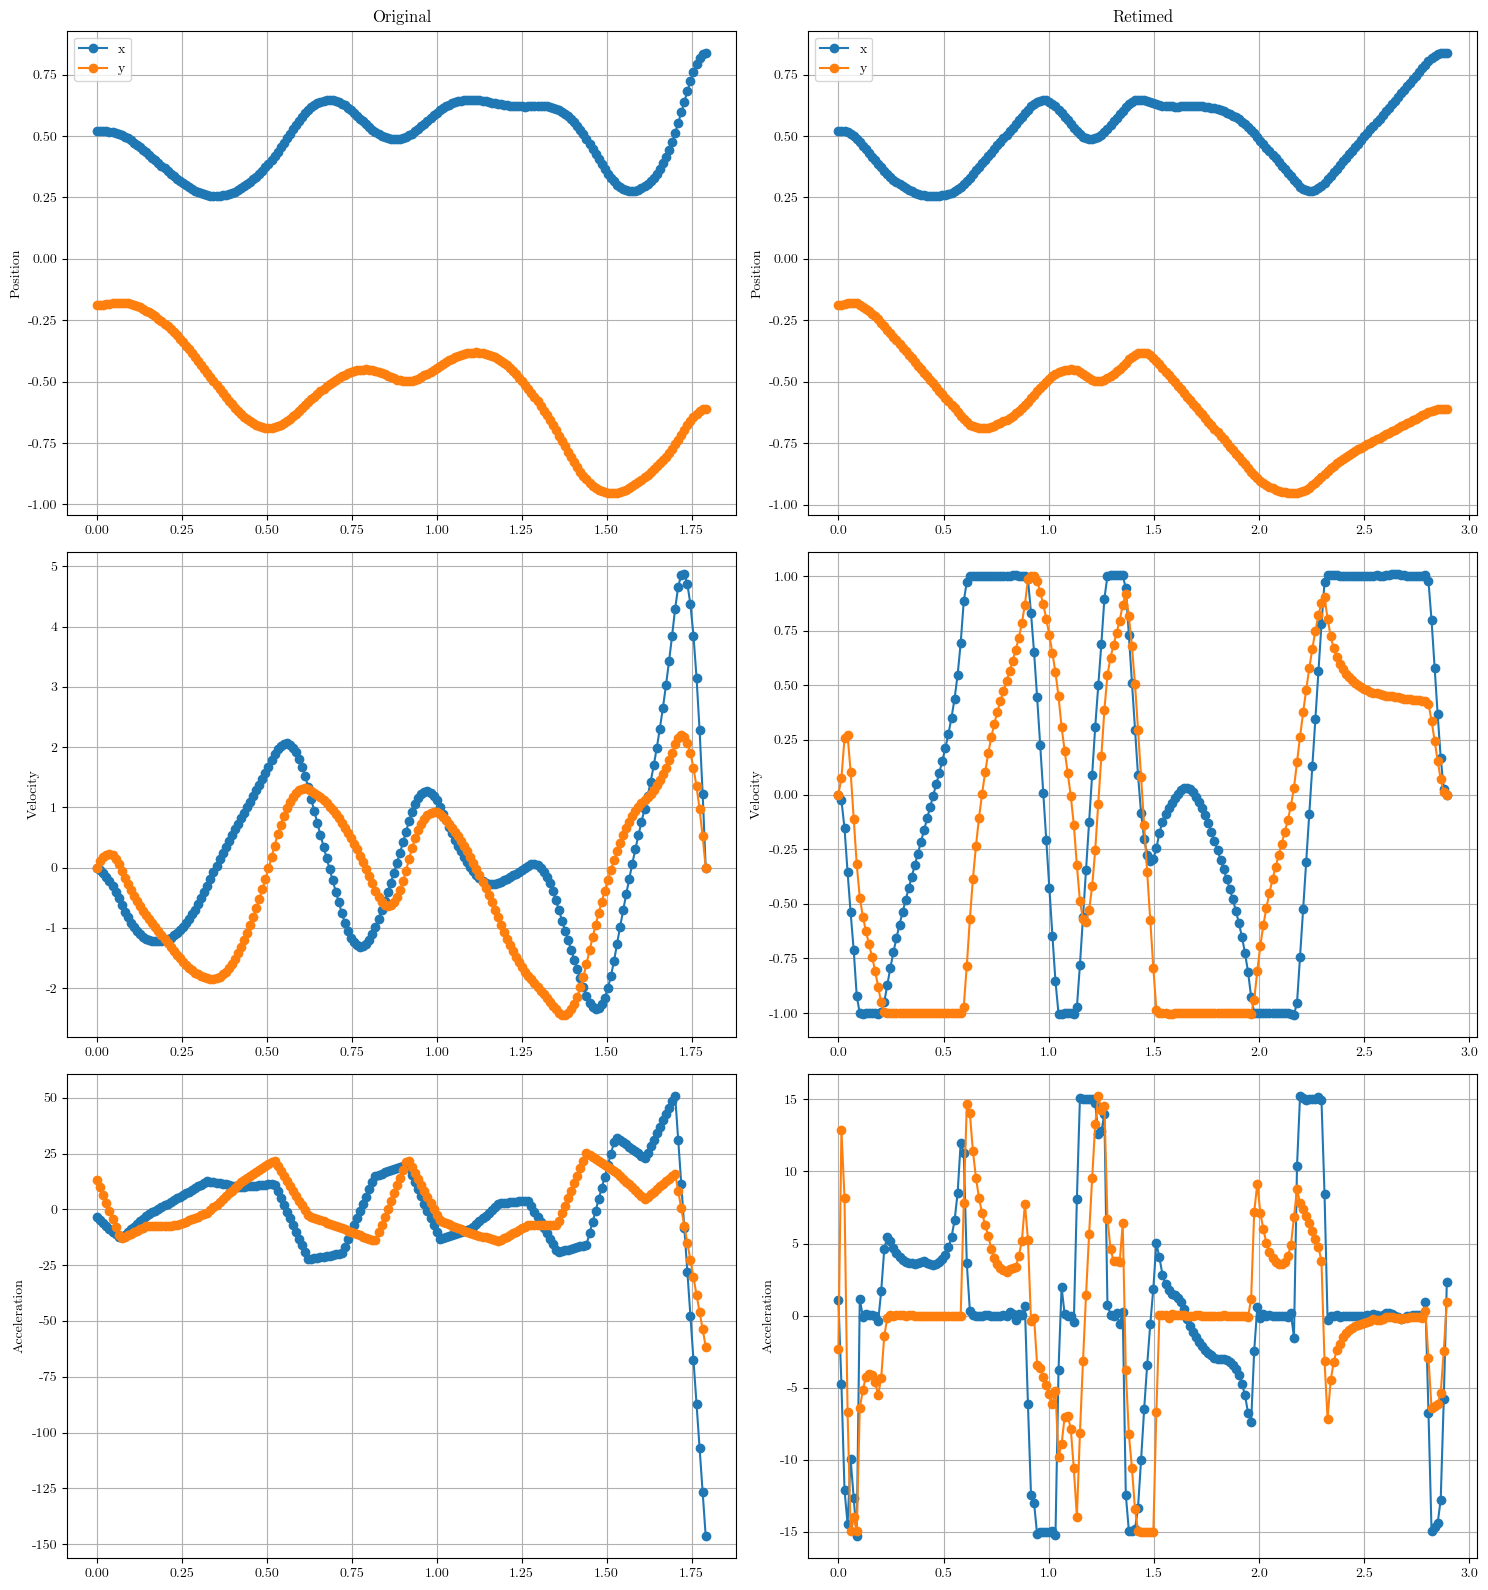

In [6]:
# Plot TOPP-RA results
# fig, axes = plt.subplots(3, 2, figsize=(5, 6))
fig, axes = plt.subplots(3, 2, figsize=(15, 16))
stroke.plot_xva(axes)
fig.tight_layout()

In [7]:
# Create html animation
HTML(stroke.create_html_anim('test1.html'))

# Investigate the data format of `toppra.SplineInterpolator`
(to reverse-engineer)

In [8]:
coeff = stroke.path.cspl.c
coeffv = stroke.path.cspld.c
breakpts = stroke.path.cspl.x
print(coeff.shape) # (degree, numsegments, xy)
print(breakpts.shape) # (numsegments+1)

(4, 20, 2)
(21,)


In [9]:
print(coeff.shape, coeffv.shape) # coeffv should have degree 1 less than coeff
print(coeff[:, 10, 0])
print(coeffv[:, 10, 0])
print(coeff[:, 10, 0] * np.arange(3, -1, -1)) # manually take the derivative to compare to coeffv

(4, 20, 2) (3, 20, 2)
[-59.4779488   10.20059626   0.68244614   0.49897959]
[-178.4338464    20.40119252    0.68244614]
[-178.4338464    20.40119252    0.68244614    0.        ]


In [10]:
# Now try to manually evaluate the piecewise polynomial!
t = np.array([6e-4, 0.2, 0.4, 0.6, 1])
expected = stroke.path(t)
print(expected)

# manually evaluate the spline
t2 = t.reshape(-1, 1)
cond = np.logical_and(t2 >= breakpts[:-1].reshape(1, -1), t2 < breakpts[1:].reshape(1, -1))
xy = []
for t_, col in zip(t, cond):
    coeff_ = coeff[:, col, :].squeeze()
    N = coeff_.shape[0] - 1
    t_ = t_ - breakpts[:-1][col]
    tpow = np.power(t_, np.arange(N, -1, -1)).reshape(1, -1)
    xy.append(tpow @ coeff_)
actual = np.array(xy).squeeze()
print(actual)
print(expected - actual)

[[ 0.52142792 -0.18775271]
 [ 0.36623731 -0.26624792]
 [ 0.27096565 -0.59740986]
 [ 0.57306148 -0.61182348]
 [ 0.59576862 -0.44172168]]
[[ 0.52142792 -0.18775271]
 [ 0.36623731 -0.26624792]
 [ 0.27096565 -0.59740986]
 [ 0.57306148 -0.61182348]
 [ 0.59576862 -0.44172168]]
[[ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -5.55111512e-17]
 [-5.55111512e-17  0.00000000e+00]
 [ 1.11022302e-16 -1.11022302e-16]
 [ 1.11022302e-16 -5.55111512e-17]]


In [11]:
# Implemented the above code in `topp.manually_evaluate_spline`
# Test `topp.manually_evaluate_spline`
t = np.array([6e-4, 0.2, 0.4, 0.6, 1])
expected = stroke.path(t)
actual = topp.manually_evaluate_spline(t, stroke.path)
np.testing.assert_allclose(actual, expected, rtol=1e-15, atol=1e-15)

# Create data for c++ unit tests

In [12]:
xc = [1, 2, 3, 4]
yc = [5, 6, 7, 8]
t = 0.1
xdc, ydc = np.polyder(xc), np.polyder(yc)
xddc, yddc = np.polyder(xdc), np.polyder(ydc)
for t in [0.05, 0.09999999]:
    print(f'EXPECT_XVA_EQUAL({t}, 1e-6,             // t, tol')
    print(f'                 {np.polyval(xc, t):.6f}, {np.polyval(yc, t):.6f},    // x')
    print(f'                 {np.polyval(xdc, t):.6f}, {np.polyval(ydc, t):.6f},    // v')
    print(f'                 {np.polyval(xddc, t):.6f}, {np.polyval(yddc, t):.6f});  // a')

EXPECT_XVA_EQUAL(0.05, 1e-6,             // t, tol
                 4.155125, 8.365625,    // x
                 3.207500, 7.637500,    // v
                 4.300000, 13.500000);  // a
EXPECT_XVA_EQUAL(0.09999999, 1e-6,             // t, tol
                 4.321000, 8.765000,    // x
                 3.430000, 8.350000,    // v
                 4.600000, 15.000000);  // a


In [13]:
for i in range(4):
    b = breakpts[i+1]
    c = coeff[:, i, :].squeeze()
    row2str = lambda row: ', '.join(f'{n:.6f}' for n in row)
    print(f'spline.add_segment({b}, {{{{ {{{{ {row2str(c[:, 0])} }}}}, {{{{ {row2str(c[:, 1])} }}}} }}}});')

spline.add_segment(0.06724042950513556, {{ {{ -23.615486, -1.797440, 0.000000, 0.521429 }}, {{ -65.875805, 6.686421, 0.000000, -0.187755 }} }});
spline.add_segment(0.1462418300653595, {{ {{ 22.029079, -6.561186, -0.562038, 0.506122 }}, {{ 12.298036, -6.602131, 0.005668, -0.177551 }} }});
spline.add_segment(0.23255045607986782, {{ {{ 14.475169, -1.340202, -1.186258, 0.431633 }}, {{ 0.311079, -3.687445, -0.807223, -0.212245 }} }});
spline.add_segment(0.3247354377648495, {{ {{ 14.056371, 2.407794, -1.094116, 0.328571 }}, {{ 10.211883, -3.606899, -1.436788, -0.309184 }} }});


In [14]:
for t in [0.005, 0.01, 0.015, breakpts[2], 0.035, 0.045]:
    print(f'EXPECT_XVA_EQUAL({t}, 1e-6,            // t, tol')
    print(f'                 {row2str(stroke.path.eval(t))},  // x')
    print(f'                 {row2str(stroke.path.evald(t))},  // v')
    print(f'                 {row2str(stroke.path.evaldd(t))});  // a')
t = breakpts[4]
print(f'EXPECT_XVA_EQUAL({0.05}, 1e-6,            // t, tol')
print(f'                 {row2str(stroke.path.eval(t))},  // x')
print(f'                 {row2str(stroke.path.evald(t))},  // v')
print(f'                 {row2str(stroke.path.evaldd(t))});  // a')

EXPECT_XVA_EQUAL(0.005, 1e-6,            // t, tol
                 0.521381, -0.187596,  // x
                 -0.019746, 0.061924,  // v
                 -4.303344, 11.396567);  // a
EXPECT_XVA_EQUAL(0.01, 1e-6,            // t, tol
                 0.521225, -0.187152,  // x
                 -0.043033, 0.113966,  // v
                 -5.011808, 9.420293);  // a
EXPECT_XVA_EQUAL(0.015, 1e-6,            // t, tol
                 0.520944, -0.186473,  // x
                 -0.069864, 0.156126,  // v
                 -5.720273, 7.444019);  // a
EXPECT_XVA_EQUAL(0.1462418300653595, 1e-6,            // t, tol
                 0.431633, -0.212245,  // x
                 -1.186258, -0.807223,  // v
                 -2.680403, -7.374891);  // a
EXPECT_XVA_EQUAL(0.035, 1e-6,            // t, tol
                 0.518214, -0.182389,  // x
                 -0.212608, 0.225956,  // v
                 -8.554131, -0.461077);  // a
EXPECT_XVA_EQUAL(0.045, 1e-6,            // t, tol
             

# Re-scale and Send over serial to robot

In [15]:
PORT = '/dev/tty.usbmodem100994303'

(<toppra.algorithm.reachabilitybased.time_optimal_algorithm.TOPPRA at 0x169d08dc0>,
 <toppra.parametrizer.ParametrizeSpline at 0x169cf5580>)

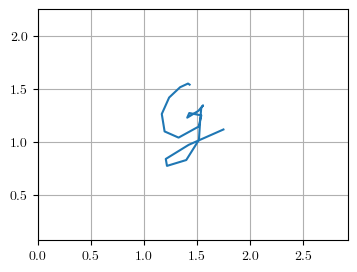

In [16]:
W, H = 2.92, 2.32
center = np.mean([np.max(stroke.x, axis=0), np.min(stroke.x, axis=0)], axis=0)
newx = stroke.x - center + [W / 2, H / 2]
stroke = topp.Stroke(np.hstack((stroke.t.reshape(-1, 1), newx)),
                     clean=False)
plt.figure(figsize=(4, 3))
plt.plot(*stroke.x.T)
plt.axis('equal')
plt.xlim(0, W)
plt.ylim(0, H);
stroke.retime()

In [17]:
io.send_spline_serial(stroke.retimed_path.cspl, PORT)

SerialException: [Errno 2] could not open port /dev/tty.usbmodem100994303: [Errno 2] No such file or directory: '/dev/tty.usbmodem100994303'

In [ ]:
t, x, v, _ = stroke.sample_retimed(dt=0.1)
print('Ground Truth:')
print(np.hstack((t[:10].reshape(-1, 1), x[:10], v[:10])))
print('Read back from robot:')
with CableRobot(print_raw=True, write_timeout=None, initial_msg='d10,100', port=PORT) as robot:
    robot.send('t*')
    io.read_spline_serial(robot, num_lines=10)